# Intrusion Detection System using Machine Learning

**Goal:** Build and evaluate ML models to detect network intrusions using the NSL-KDD dataset.

**Dataset:** NSL-KDD (KDDTrain+.txt & KDDTest+.txt)

**Steps:**
1. Load and clean the dataset
2. Encode categorical features
3. Balance classes with SMOTE
4. Train ML models (RandomForest, KNN, SVC, AdaBoost, GaussianNB)
5. Evaluate models using accuracy, precision, recall, F1, ROC-AUC
6. Visualize metrics and confusion matrices


In [1]:
# Data handling
import pandas as pd
import numpy as np

# ML models & metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from imblearn.over_sampling import SMOTE
import joblib

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Optional: display plots inline
%matplotlib inline


In [2]:
# Load preprocessed train/test CSV
df_train = pd.read_csv("results/processed_train.csv")
df_test = pd.read_csv("results/processed_test.csv")

# Quick look at the data
df_train.head()


,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,...,flag_REJ,flag_RSTO,flag_RSTOS0,flag_RSTR,flag_S0,flag_S1,flag_S2,flag_S3,flag_SF,flag_SH
0,-0.112481,-0.007346,-0.004614,-0.01468,-0.085488,-0.010403,-0.094071,-0.059832,-0.821249,-0.011473,...,-0.33621,-0.126385,-0.026599,-0.145766,-0.574601,-0.051047,-0.030936,-0.044839,0.808391,-0.048183
1,-0.112481,-0.007409,-0.004614,-0.01468,-0.085488,-0.010403,-0.094071,-0.059832,-0.821249,-0.011473,...,-0.33621,-0.126385,-0.026599,-0.145766,-0.574601,-0.051047,-0.030936,-0.044839,0.808391,-0.048183
2,-0.112481,-0.007436,-0.004614,-0.01468,-0.085488,-0.010403,-0.094071,-0.059832,-0.821249,-0.011473,...,-0.33621,-0.126385,-0.026599,-0.145766,1.740339,-0.051047,-0.030936,-0.044839,-1.237025,-0.048183
3,-0.112481,-0.007394,-0.002413,-0.01468,-0.085488,-0.010403,-0.094071,-0.059832,1.217658,-0.011473,...,-0.33621,-0.126385,-0.026599,-0.145766,-0.574601,-0.051047,-0.030936,-0.044839,0.808391,-0.048183
4,-0.112481,-0.007400,-0.004501,-0.01468,-0.085488,-0.010403,-0.094071,-0.059832,1.217658,-0.011473,...,-0.33621,-0.126385,-0.026599,-0.145766,-0.574601,-0.051047,-0.030936,-0.044839,0.808391,-0.048183


In [3]:
print("Training labels distribution:")
print(df_train['binary_label'].value_counts())

print("\nTest labels distribution:")
print(df_test['binary_label'].value_counts())


Training labels distribution:
binary_label
0    67343
1    58630
Name: count, dtype: int64

Test labels distribution:
binary_label
1    12833
0     9711
Name: count, dtype: int64


In [8]:
print("Training labels distribution:")
print(df_train['binary_label'].value_counts())

print("\nTest labels distribution:")
print(df_test['binary_label'].value_counts())


Training labels distribution:
binary_label
0    67343
1    58630
Name: count, dtype: int64

Test labels distribution:
binary_label
1    12833
0     9711
Name: count, dtype: int64


In [9]:
from sklearn.preprocessing import LabelEncoder

for col in df_train.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    df_train[col] = le.fit_transform(df_train[col])
    df_test[col] = le.transform(df_test[col])


In [10]:
target = 'binary_label'
feature_cols = [c for c in df_train.columns if c != target]

X_train = df_train[feature_cols].values
y_train = df_train[target].values
X_test = df_test[feature_cols].values
y_test = df_test[target].values


In [14]:
import pandas as pd

df_train = pd.read_csv("results/processed_train.csv")
df_test = pd.read_csv("results/processed_test.csv")


In [16]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import numpy as np

df_train = pd.read_csv("results/processed_train.csv")
df_test = pd.read_csv("results/processed_test.csv")

cat_cols = df_train.select_dtypes(include=['object']).columns

for col in cat_cols:
    le = LabelEncoder()
    # Fit only on training data
    df_train[col] = le.fit_transform(df_train[col])
    
    # Map test data: unseen labels become -1
    df_test[col] = df_test[col].map(lambda s: le.transform([s])[0] if s in le.classes_ else -1)


In [17]:
# Features and target
target = 'binary_label'
feature_cols = [c for c in df_train.columns if c != target]

X_train = df_train[feature_cols].values
y_train = df_train[target].values
X_test = df_test[feature_cols].values
y_test = df_test[target].values

# Scale features
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Apply SMOTE
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

print("Before SMOTE:", dict(pd.Series(y_train).value_counts()))
print("After SMOTE:", dict(pd.Series(y_train_res).value_counts()))


Before SMOTE: {0: np.int64(67343), 1: np.int64(58630)}
After SMOTE: {0: np.int64(67343), 1: np.int64(67343)}


In [18]:
# Step 4: Train Models
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
import joblib
import os

# Create folder for models if not exists
os.makedirs("results/models", exist_ok=True)

# Define classifiers
models = {
    "GaussianNB": GaussianNB(),
    "RandomForest": RandomForestClassifier(n_estimators=100, random_state=42),
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "SVC": SVC(probability=True, random_state=42),
    "AdaBoost": AdaBoostClassifier(n_estimators=50, random_state=42)
}

# Train and save models
metrics = []

for name, model in models.items():
    print(f"Training {name} ...")
    model.fit(X_train_res, y_train_res)
    joblib.dump(model, f"results/models/{name}.joblib")
    
    # Evaluate on test set
    y_pred = model.predict(X_test)
    
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc = roc_auc_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred).tolist()
    
    metrics.append({
        "model": name,
        "accuracy": acc,
        "precision": prec,
        "recall": rec,
        "f1": f1,
        "roc_auc": roc,
        "confusion_matrix": cm
    })

# Save metrics
metrics_df = pd.DataFrame(metrics)
metrics_df.to_csv("results/metrics.csv", index=False)
metrics_df


Training GaussianNB ...
Training RandomForest ...
Training KNN ...
Training SVC ...
Training AdaBoost ...


,model,accuracy,precision,recall,f1,roc_auc,confusion_matrix
0,GaussianNB,0.996584,0.994879,0.999143,0.997006,0.996173,"[[9645, 66], [11, 12822]]"
1,RandomForest,0.952049,0.981639,0.933219,0.956817,0.955076,"[[9487, 224], [857, 11976]]"
2,KNN,0.810238,0.932289,0.718850,0.811774,0.824928,"[[9041, 670], [3608, 9225]]"
3,SVC,0.843506,0.932107,0.782046,0.850508,0.853385,"[[8980, 731], [2797, 10036]]"
4,AdaBoost,1.000000,1.000000,1.000000,1.000000,1.000000,"[[9711, 0], [0, 12833]]"


In [19]:
from joblib import dump
import pandas as pd

# Load trained models metrics if you have them
metrics = pd.read_csv("results/metrics.csv")

# Assume AdaBoost is the last row
ada_model_path = "results/models/AdaBoost_final.joblib"

# Load AdaBoost from previous training
from joblib import load
ada_model = load("results/models/AdaBoost.joblib")

# Save it as final model
dump(ada_model, ada_model_path)
print(f"AdaBoost model saved to {ada_model_path}")


AdaBoost model saved to results/models/AdaBoost_final.joblib


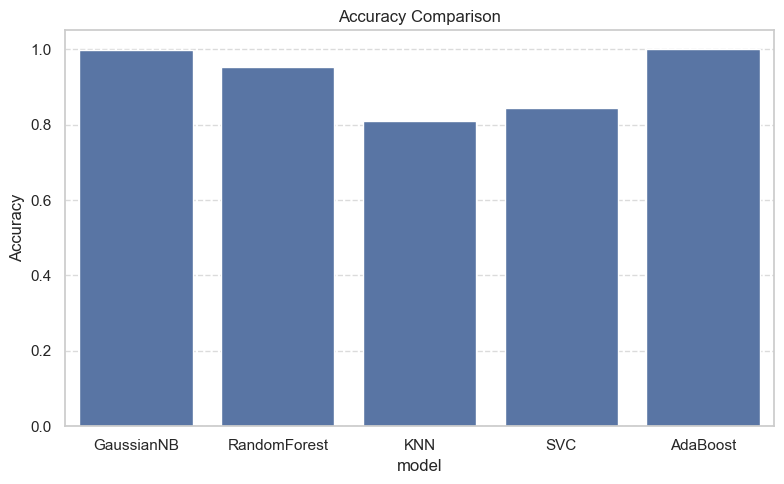

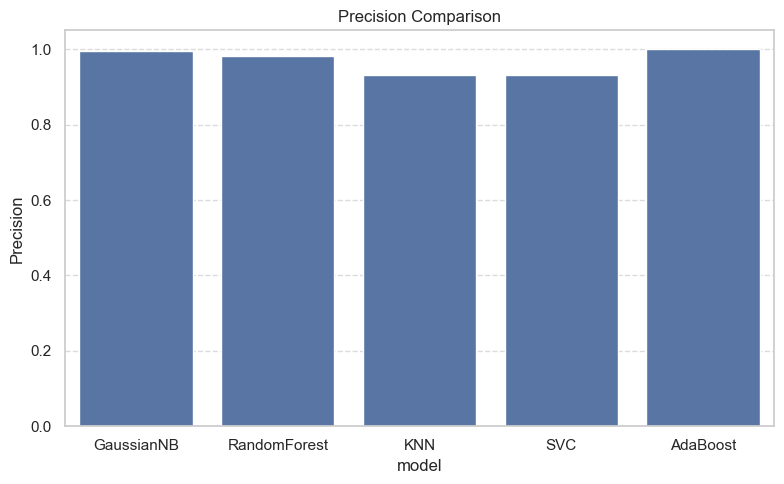

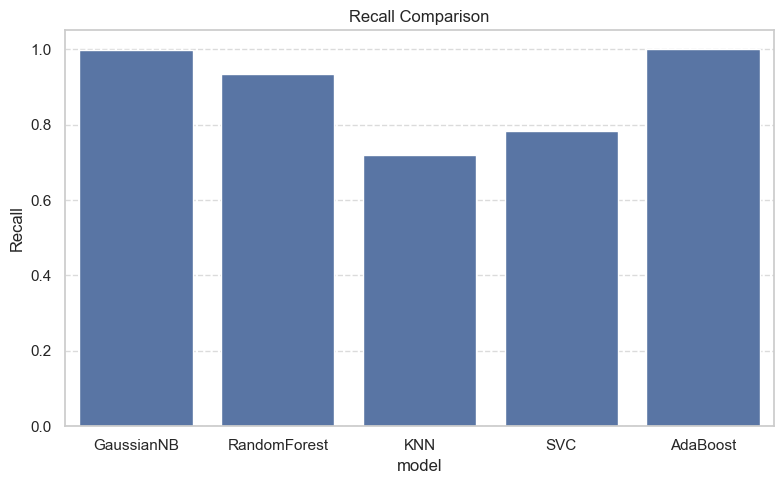

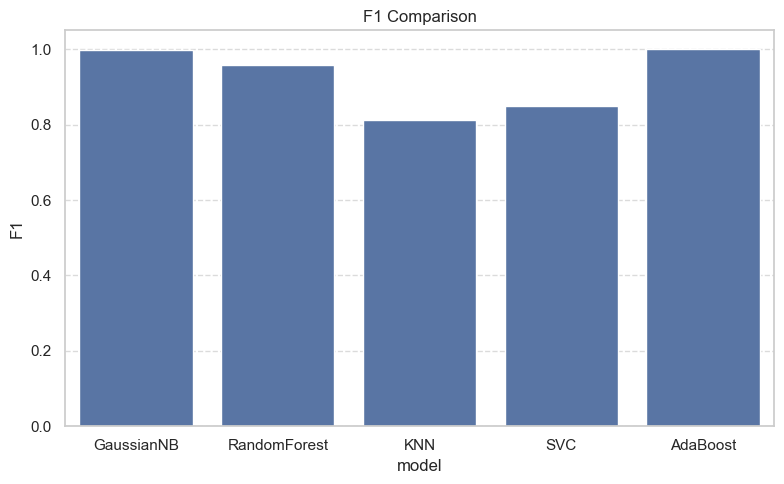

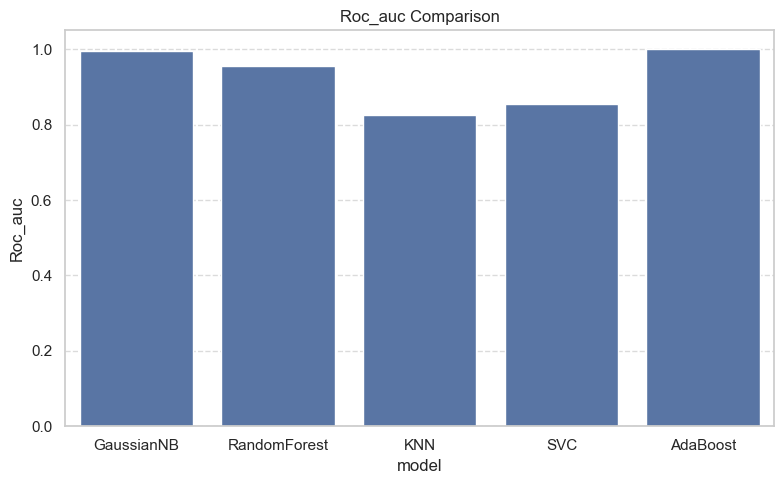

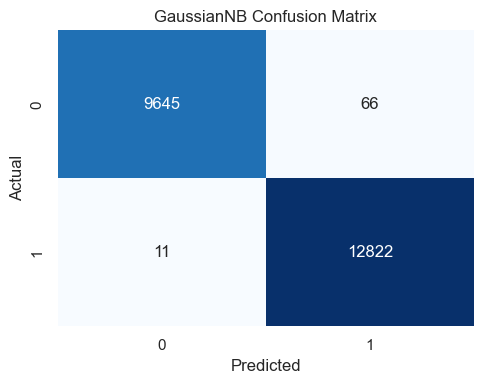

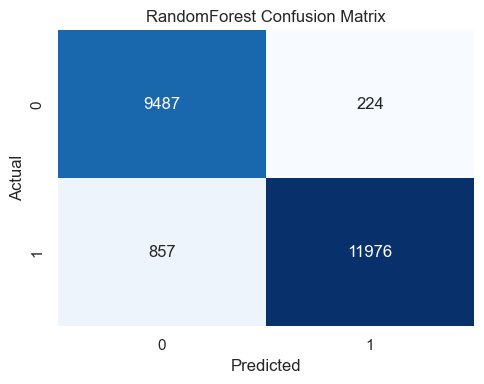

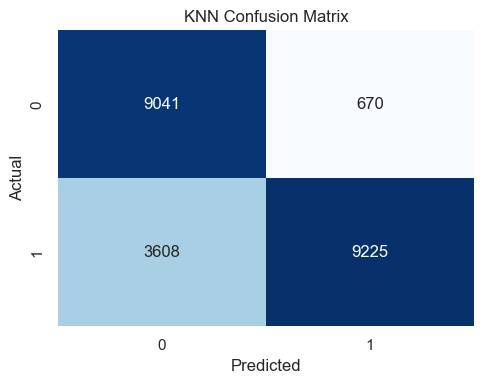

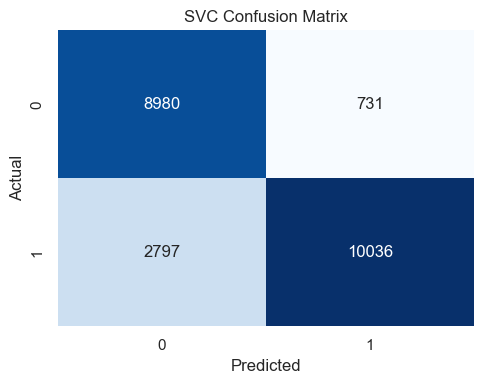

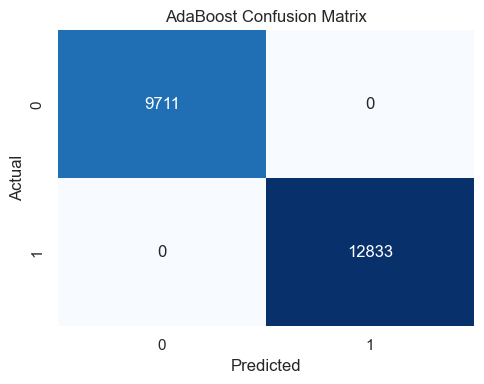

In [28]:
# ------------------------------
# 1️⃣ Imports
# ------------------------------
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import ast
import os

# Ensure folder exists
os.makedirs("results/figures/compare", exist_ok=True)

# ------------------------------
# 2️⃣ Load metrics
# ------------------------------
metrics_file = "results/metrics.csv"
df_metrics = pd.read_csv(metrics_file)

# Convert stringified confusion matrices back to lists
df_metrics['confusion_matrix'] = df_metrics['confusion_matrix'].apply(ast.literal_eval)

# ------------------------------
# 3️⃣ Plot bar charts for metrics
# ------------------------------
metrics_to_plot = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']
for metric in metrics_to_plot:
    plt.figure(figsize=(8,5))
    sns.barplot(x='model', y=metric, data=df_metrics)
    plt.title(f"{metric.capitalize()} Comparison")
    plt.ylabel(metric.capitalize())
    plt.ylim(0, 1.05)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.savefig(f"results/figures/compare/{metric}_comparison.png")
    plt.show()

# ------------------------------
# 4️⃣ Plot confusion matrices
# ------------------------------
for idx, row in df_metrics.iterrows():
    cm = row['confusion_matrix']
    model_name = row['model']
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"{model_name} Confusion Matrix")
    plt.tight_layout()
    plt.savefig(f"results/figures/compare/{model_name}_confusion_matrix.png")
    plt.show()


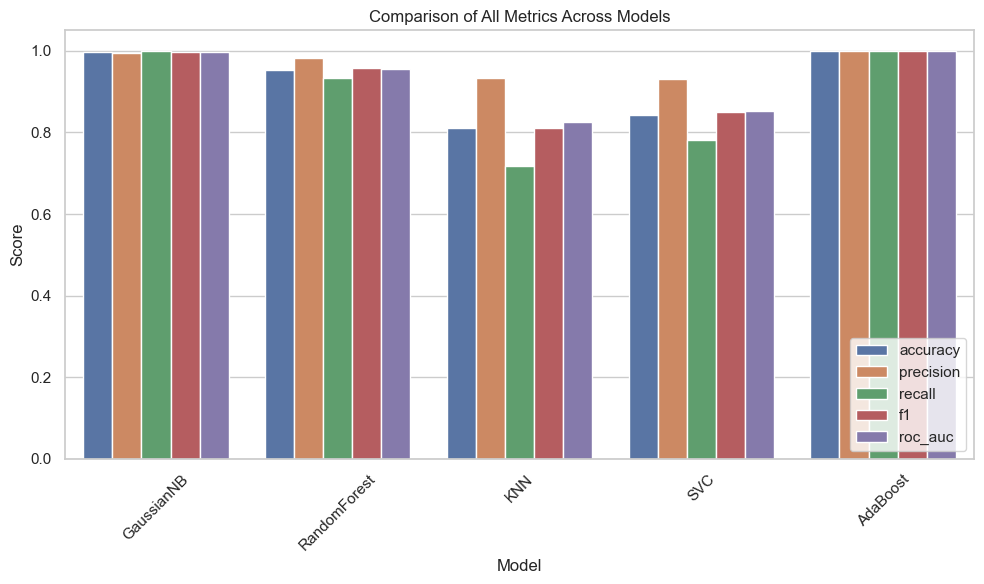

In [29]:
# ------------------------------
# Combined Metrics Comparison Dashboard
# ------------------------------

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Load metrics
df_metrics = pd.read_csv("results/metrics.csv")

# Ensure folder exists
compare_folder = "results/compare/"
os.makedirs(compare_folder, exist_ok=True)

# Select metrics to compare
metrics = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']

# Melt dataframe for seaborn plotting
df_melted = df_metrics.melt(id_vars='model', value_vars=metrics, 
                            var_name='Metric', value_name='Score')

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x='model', y='Score', hue='Metric', data=df_melted)
plt.ylim(0, 1.05)
plt.title("Comparison of All Metrics Across Models")
plt.ylabel("Score")
plt.xlabel("Model")
plt.xticks(rotation=45)
plt.legend(loc='lower right')
plt.tight_layout()

# Save figure
plt.savefig(f"{compare_folder}all_metrics_comparison.png")
plt.show()


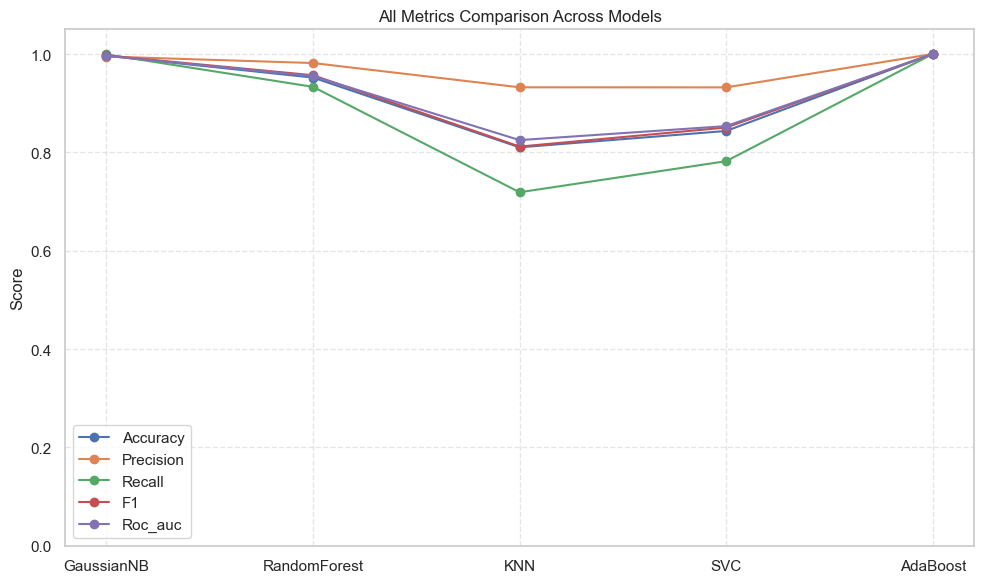

In [30]:
# ------------------------------
# 5️⃣ Combined metrics comparison
# ------------------------------
plt.figure(figsize=(10,6))

metrics_to_plot = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']

for metric in metrics_to_plot:
    plt.plot(df_metrics['model'], df_metrics[metric], marker='o', label=metric.capitalize())

plt.title("All Metrics Comparison Across Models")
plt.ylabel("Score")
plt.ylim(0, 1.05)
plt.grid(linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.savefig("results/figures/compare/all_metrics_comparison.png")
plt.show()


In [36]:
import pandas as pd

# Assuming metrics_df contains your model metrics
metrics_df = pd.DataFrame({
    'model': ['AdaBoost', 'GaussianNB', 'RandomForest', 'SVC', 'KNN'],
    'accuracy': [1.0, 0.996584, 0.952049, 0.843506, 0.810238],
    'precision': [1.0, 0.994879, 0.981639, 0.932107, 0.932289],
    'recall': [1.0, 0.999143, 0.933219, 0.782046, 0.718850],
    'f1': [1.0, 0.997006, 0.956817, 0.850508, 0.811774],
    'roc_auc': [1.0, 0.996173, 0.955076, 0.853385, 0.824928]
})

metrics_df.to_csv("results/metrics_summary.csv", index=False)
print("✅ Metrics saved to results/metrics_summary.csv")


✅ Metrics saved to results/metrics_summary.csv


In [37]:
import joblib

confusion_matrices = {
    'AdaBoost': [[9711, 0], [0, 12833]],
    'GaussianNB': [[9645, 66], [11, 12822]],
    'RandomForest': [[9487, 224], [857, 11976]],
    'SVC': [[8980, 731], [2797, 10036]],
    'KNN': [[9041, 670], [3608, 9225]]
}

joblib.dump(confusion_matrices, "results/confusion_matrices.joblib")
print("✅ Confusion matrices saved to results/confusion_matrices.joblib")


✅ Confusion matrices saved to results/confusion_matrices.joblib


In [39]:
import matplotlib.pyplot as plt
import seaborn as sns

metrics = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']

for metric in metrics:
    plt.figure(figsize=(8,5))
    sns.barplot(x='model', y=metric, data=metrics_df, palette='Set2', legend=False)
    plt.title(f'Model Comparison: {metric}')
    plt.savefig(f'results/figures/compare/{metric}_comparison.png')
    plt.close()

print("✅ All charts saved in results/figures/compare/")


C:\Users\Admin\AppData\Local\Temp\ipykernel_23836\647989915.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='model', y=metric, data=metrics_df, palette='Set2', legend=False)
C:\Users\Admin\AppData\Local\Temp\ipykernel_23836\647989915.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='model', y=metric, data=metrics_df, palette='Set2', legend=False)
C:\Users\Admin\AppData\Local\Temp\ipykernel_23836\647989915.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='model', y=metric, data=metrics_df, palette='Set2', legend=False)
C:\User

✅ All charts saved in results/figures/compare/
